# News Article Matching

## Load Data

In [1]:
import pandas as pd

In [2]:
DATA_PATH = '/Users/michaelwellner/Workspaces/thesis--news-crawler/export'
METADATA_FILE = f"{DATA_PATH}/_items.csv"

def load_text(row, data_path = DATA_PATH):
    hash = row['hash']
    with open(f"{data_path}/{hash}.content.txt", 'r') as file:
        return file.read()

data = pd.read_csv(METADATA_FILE)
data['crawled'] = pd.to_datetime(data['crawled'])
data['text'] = data.apply(lambda row: load_text(row), axis = 1)

Spiegel Online    580
ARD Teletext      260
Name: type, dtype: int64

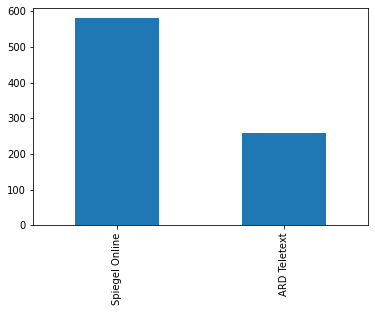

In [3]:
data['type'].value_counts().plot(kind='bar')
data['type'].value_counts()

In [45]:
data.head()

,crawled,hash,source,title,type,text
0,2020-11-03 10:00:00.970729+00:00,466c496cfcbc46116e0251e1401a363617ea8b14535e85...,https://www.spiegel.de/politik/ausland/elfenbe...,Umstrittene dritte Amtszeit Präsident Ouattara...,Spiegel Online,Es ist vordergründig ein klarer Sieg für Präsi...
1,2020-11-02 04:45:18.456830+00:00,275dc21a0349d3a70b87f37f863f6b6e00b4336e4e1e6f...,https://www.spiegel.de/wissenschaft/coronaviru...,+++ Coronavirus-Update +++ Robert Koch-Institu...,Spiegel Online,Nichts mehr verpassen: Für die neuesten Entwic...
2,2020-11-02 17:15:15.563462+00:00,410bd53acf4da944e1690ba90805e472f3c796dec626e6...,https://www.spiegel.de/wirtschaft/soziales/cor...,Umgang mit Corona-Schulden Rechnungshof wirft ...,Spiegel Online,Der Bundesrechnungshof kritisiert in einem neu...
3,2020-11-01 21:00:00.802997+00:00,4a7428de589b9273c2cd48690bccde9fa63b17312e8389...,https://www.spiegel.de/politik/ausland/belarus...,Proteste in Minsk Sicherheitskräfte gehen mass...,Spiegel Online,Bei neuen Massenprotesten in Belarus haben sic...
4,2020-11-02 17:15:15.193508+00:00,b75d8cdffb2d523f1dd15c03906753e2486e201470d2eb...,https://www.spiegel.de/politik/ausland/afghani...,Afghanistan Mindestens 19 Tote bei Angriff auf...,Spiegel Online,Bei einem Angriff auf die Universität von Kabu...


## TF-IDF Matching

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import spacy

nlp = spacy.load('de_core_news_lg')

In [15]:
example_corpus = [
    "Monsters are bad.", \
    "I saw a monster yesterday.", \
    "Why are we talking about bad monsters?"]

In [46]:
def spacy_tokenizer(document):
    tokens = nlp(document)
    tokens = [token.lemma_ for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

In [65]:
tfidf_vectorizer = TfidfVectorizer(input = 'content', tokenizer = spacy_tokenizer, token_pattern = None)

In [66]:
documents = data["text"]
tfidf_vectorizer.fit(documents)

TfidfVectorizer(token_pattern=None,
                tokenizer=<function spacy_tokenizer at 0x7fa13256e940>)

In [222]:
from sklearn.metrics.pairwise import linear_kernel

def find_best_match(row, rows, window = pd.Timedelta(hours = 4)):
    filter = ((rows['crawled'] > row['crawled'] - window) & (rows['crawled'] < row['crawled'] + window))
    
    if (filter.sum()) > 1:
        rows = rows[filter]
        
    row_tokens = tfidf_vectorizer.transform([row['text']])
    rows_tokens = tfidf_vectorizer.transform(rows['text'])
    similarities = pd.Series(linear_kernel(row_tokens, rows_tokens).flatten())
    
    result_rows = rows.copy()
    result_rows['score'] = similarities.array
    result_rows['summary_hash'] = row['hash']
    
    return result_rows.iloc[similarities.idxmax()]

In [223]:
data_summaries = data[data["type"] == "ARD Teletext"]
data_texts = data[data["type"] == "Spiegel Online"]
find_best_match(data_summaries.iloc[0], data_texts[0:4])

crawled                          2020-11-02 04:45:18.456830+00:00
hash            275dc21a0349d3a70b87f37f863f6b6e00b4336e4e1e6f...
source          https://www.spiegel.de/wissenschaft/coronaviru...
title           +++ Coronavirus-Update +++ Robert Koch-Institu...
type                                               Spiegel Online
text            Nichts mehr verpassen: Für die neuesten Entwic...
score                                                   0.0246695
summary_hash    03db3913f261b620a2673591cdbea2f3cf390f8e70501f...
Name: 1, dtype: object

In [240]:
from tqdm.auto import tqdm 
tqdm.pandas()

select = data_summaries
matches = select.progress_apply(lambda row: find_best_match(row, data_texts), axis = 1)
merged = pd.merge(
    select, matches, 
    how='left', left_on=['hash'], right_on=['summary_hash'],
    suffixes=['_summary', '_document'])

/Users/michaelwellner/Workspaces/thesis--news-matching/env/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [246]:
pd.set_option('display.max_rows', 300)
merged[['title_summary', 'title_document', 'text_summary', 'text_document', 'score', 'hash_summary', 'hash_document']].sort_values('score', ascending=False)

,title_summary,title_document,text_summary,text_document,score,hash_summary,hash_document
240,Auflagen für Kaffeefahrten geplant,Abzocke von Senioren Lambrecht plant härtere A...,\n\nBei Kaffeefahrten sollen nach dem Willen v...,Bei Kaffeefahrten sollen nach dem Willen von J...,0.677857,eb9aafa7297a63ee2be8d6d8a9869df9a2d251bbd22577...,43c46d379668af2a1728dc99b6bdedb0f868380bcd20db...
243,Woidke mit Coronavirus infiziert,"""Ich habe leichte Symptome"" Brandenburgs Regie...",Brandenburgs Ministerpräsident Woidke ist posi...,Brandenburgs Ministerpräsident Dietmar Woidke ...,0.626467,53f5ed62539b8de015a51542474faed40f324f1280dd10...,2737f0a0946c1b5a085d66f44c5017191404af3285a177...
11,Mehrere Politiker in Quarantäne,"""Ich habe leichte Symptome"" Brandenburgs Regie...",Nach der Corona-Diagnose von Brandenburgs Regi...,Brandenburgs Ministerpräsident Dietmar Woidke ...,0.624600,94618d47d9534aad7e5a458e98607a8cc235d344407920...,59091db4951f667bea5d930a22e2e2252a5a687c9a3f2e...
117,40 Verfahren in Berliner Polizei,Rechtsextremismus-Verdacht Berliner Polizei ge...,\n\nBei der Berliner Polizei laufen derzeit kn...,Berlins Polizeipräsidentin Barbara Slowik hat ...,0.611378,ce79cc864e8cc433eeaaec08b7341cfd1581f8550d48af...,9e475ce4b248612a737dfbd983821335afeff916d95ac6...
171,Bessere Stimmung in Autobranche,Ifo-Konjunkturumfrage Stimmung in der Autobran...,\n\nDie Stimmung in der deutschen Autoindustri...,Die Stimmung in der deutschen Autobranche wird...,0.601433,f66cbb82bb9dcbf2999d6c6e09bf7e1101da817dbbdd46...,5f38de1ff2c7a4758daccf41e0215c84ff29da7346257b...
58,Woidke mit Corona infiziert,"""Ich habe leichte Symptome"" Brandenburgs Regie...",Brandenburgs Ministerpräsident Woidke ist posi...,Brandenburgs Ministerpräsident Dietmar Woidke ...,0.596523,5592ffd8ed324bf8938be16f0c85e5eca3c1e68c2d0be2...,2737f0a0946c1b5a085d66f44c5017191404af3285a177...
145,Woidke mit Coronavirus infiziert,"""Ich habe leichte Symptome"" Brandenburgs Regie...",Brandenburgs Ministerpräsident Woidke ist posi...,Brandenburgs Ministerpräsident Dietmar Woidke ...,0.596523,0c34a616b680875cdcd9607ddc6db41aff1cef3b7aec98...,2737f0a0946c1b5a085d66f44c5017191404af3285a177...
122,Ohoven stirbt bei Verkehrsunfall,Im Alter von 74 Jahren Mittelstands-Präsident ...,\n\nDer Präsident des Bundesverbands mittelstä...,"Mario Ohoven, seit 1998 Präsident des Bundesve...",0.590381,d2e4d19d0913fb27befe3897973295c392ef0491480bc4...,d0afd7b32d85e714902bba87271f4feb63d2b8556a4ef4...
67,Deutsche Industrie wächst kräftig,"""Rasante"" Erholung laut Einkaufsmanagerindex D...",\n\nDie deutsche Industrie hat trotz der Coron...,Die deutsche Industrie hat trotz der Corona-Pa...,0.578866,2047c7a90e6e1d22f4949e512445697167fdc3a3415d72...,f085a80d5cd872bea72363580c14a096ff3f47feb3294e...
94,Haftstrafe in Missbrauchskomplex,Komplex Bergisch Gladbach 39-Jähriger wegen sc...,Im Prozess zum Missbrauchskomplex Bergisch Gla...,In einem Prozess zum Missbrauchskomplex Bergis...,0.565496,a919640eba5bf282f427c74004f9c28847334539618f85...,c1e1678acffab445d6adeac6ada5d8f187ba3d47fcdfbe...


In [250]:
len(merged[merged['score'] > 0.5])

17

In [259]:
doc = 240

print(merged.loc[doc]["hash_summary"])
print(merged.loc[doc]["hash_document"])

eb9aafa7297a63ee2be8d6d8a9869df9a2d251bbd22577bf466f1f1ce6bc2641
43c46d379668af2a1728dc99b6bdedb0f868380bcd20db252111ceb3089c42f2
